# Week 2 Assignment: CIFAR-10 Autoencoder

For this week, you will create a convolutional autoencoder for the [CIFAR10](https://www.tensorflow.org/datasets/catalog/cifar10) dataset. You are free to choose the architecture of your autoencoder provided that the output image has the same dimensions as the input image.

After training, your model should meet loss and accuracy requirements when evaluated with the test dataset. You will then download the model and upload it in the classroom for grading. 

Let's begin!

***Important:*** *This colab notebook has read-only access so you won't be able to save your changes. If you want to save your work periodically, please click `File -> Save a Copy in Drive` to create a copy in your account, then work from there.*  

## Imports

In [82]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, UpSampling2D, MaxPooling2D


## Load and prepare the dataset

The [CIFAR 10](https://www.tensorflow.org/datasets/catalog/cifar10) dataset already has train and test splits and you can use those in this exercise. Here are the general steps:

* Load the train/test split from TFDS. Set `as_supervised` to `True` so it will be convenient to use the preprocessing function we provided.
* Normalize the pixel values to the range [0,1], then return `image, image` pairs for training instead of `image, label`. This is because you will check if the output image is successfully regenerated after going through your autoencoder.
* Shuffle and batch the train set. Batch the test set (no need to shuffle).


In [70]:
# preprocessing function
def map_image(image, label):
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0

  return image, image # dataset label is not used. replaced with the same image input.

# parameters
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024


### START CODE HERE (Replace instances of `None` with your code) ###

# use tfds.load() to fetch the 'train' split of CIFAR-10
train_dataset = tfds.load("cifar10", as_supervised=True, split="train")

# preprocess the dataset with the `map_image()` function above
train_dataset = train_dataset.map(map_image)

# shuffle and batch the dataset
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(-1).repeat(20)

# use tfds.load() to fetch the 'test' split of CIFAR-10
test_dataset = tfds.load("cifar10", as_supervised=True, split="test")

# preprocess the dataset with the `map_image()` function above
test_dataset = test_dataset.map(map_image)

# batch the dataset
test_dataset = test_dataset.batch(BATCH_SIZE)

### END CODE HERE ###

## Build the Model

Create the autoencoder model. As shown in the lectures, you will want to downsample the image in the encoder layers then upsample it in the decoder path. Note that the output layer should be the same dimensions as the original image. Your input images will have the shape `(32, 32, 3)`. If you deviate from this, your model may not be recognized by the grader and may fail. 

We included a few hints to use the Sequential API below but feel free to remove it and use the Functional API just like in the ungraded labs if you're more comfortable with it. Another reason to use the latter is if you want to visualize the encoder output. As shown in the ungraded labs, it will be easier to indicate multiple outputs with the Functional API. That is not required for this assignment though so you can just stack layers sequentially if you want a simpler solution.

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 4, 4, 64)          0  

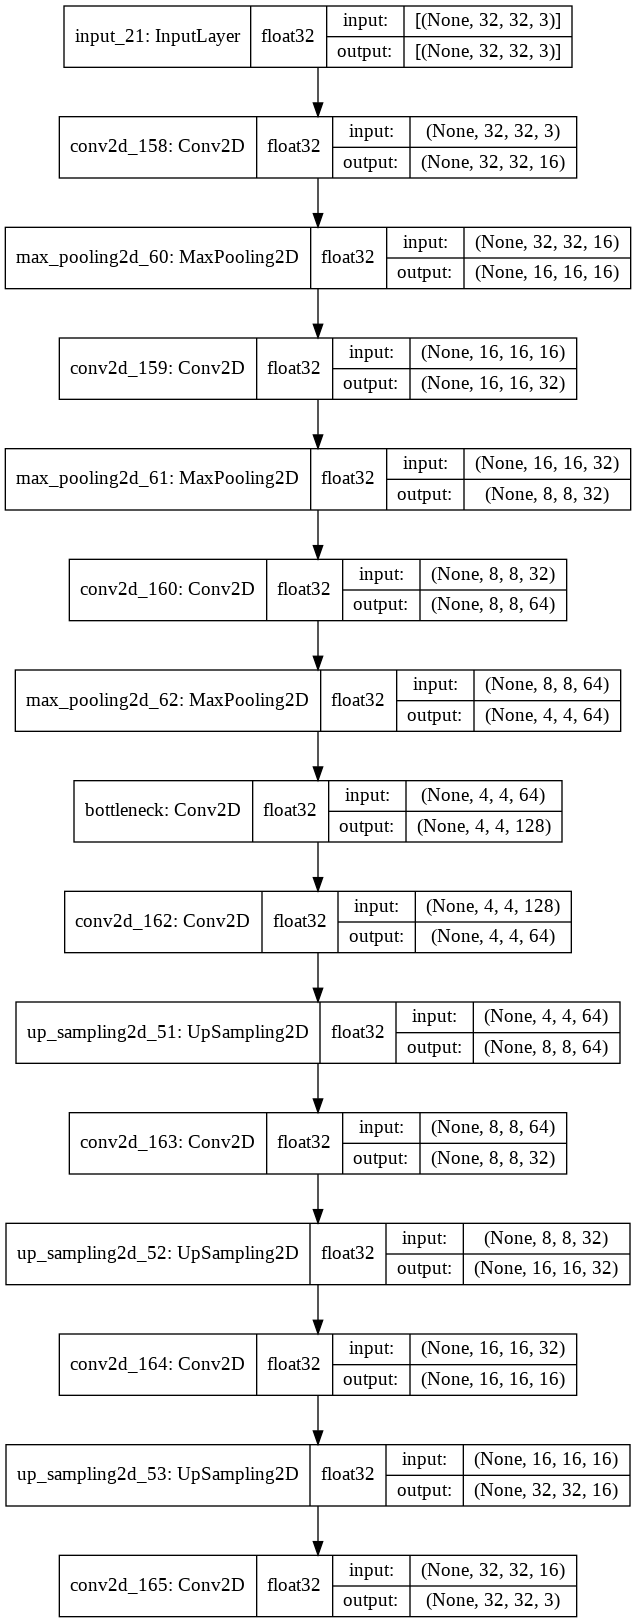

In [67]:
# suggested layers to use. feel free to add or remove as you see fit.
from keras.layers import Conv2D, UpSampling2D

# use the Sequential API (you can remove if you want to use the Functional API)

#takes in the original input, returns the encoder output.
def encoder(inputs):  
  encoder =  Conv2D(16, (3,3), padding="same", activation="relu")(inputs)
  encoder =  MaxPooling2D((2,2))(encoder)
  encoder = Conv2D(32, (3,3), padding="same", activation="relu")(encoder)
  encoder = MaxPooling2D((2,2))(encoder)
  encoder = Conv2D(64, (3,3), padding="same", activation="relu")(encoder)
  encoder = MaxPooling2D((2,2))(encoder)

  return encoder

#takes in the encoder output, does the bottleneck conv2d, returns a viz output.
def bottleneck(inputs):
  bottleneck = Conv2D(128, (3,3),padding="same", activation="relu", name = "bottleneck")(inputs)
  bottleneck_viz = Conv2D(1, (3,3), padding="same", activation="sigmoid")(bottleneck)
  
  return bottleneck, bottleneck_viz

#consumes the bottleneck output, returns the autoencoder output.
def decoder(inputs):
  decoder = Conv2D(64, (3,3), activation="relu", padding="same")(inputs)
  decoder = UpSampling2D((2,2))(decoder)
  decoder = Conv2D(32, (3,3), activation="relu", padding="same")(decoder)
  decoder = UpSampling2D((2,2))(decoder)
  decoder = Conv2D(16, (3,3), activation="relu", padding="same")(decoder)
  decoder = UpSampling2D((2,2))(decoder)
  decoder = Conv2D(3, (3,3), padding="same", activation="sigmoid")(decoder) #pixel values are normalized into [0,1] range, so last activation is sigmoid.
 
  return decoder

def cnn_autoencoder(): 
  inputs = tf.keras.layers.Input(shape=(32,32,3,))
  encoder_output = encoder(inputs)
  bottleneck_out, bottleneck_viz = bottleneck(encoder_output)
  decoder_out = decoder(bottleneck_out)
  
  autoencoder_model = tf.keras.Model(inputs = inputs, outputs= decoder_out)
  encoder_viz_model = tf.keras.Model(inputs = inputs, outputs = bottleneck_viz)

  return autoencoder_model, encoder_viz_model  

model, viz = cnn_autoencoder()




### END CODE HERE ###

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

## Configure training parameters

We have already provided the optimizer, metrics, and loss in the code below.

In [68]:
# Please do not change the model.compile() parameters
model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')

## Training

You can now use [model.fit()](https://keras.io/api/models/model_training_apis/#fit-method) to train your model. You will pass in the `train_dataset` and you are free to configure the other parameters. As with any training, you should see the loss generally going down and the accuracy going up with each epoch. If not, please revisit the previous sections to find possible bugs.

*Note: If you get a `dataset length is infinite` error. Please check how you defined `train_dataset`. You might have included a [method that repeats the dataset indefinitely](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat).*

In [71]:
# parameters (feel free to change this)
train_steps = len(train_dataset) // BATCH_SIZE 
val_steps = len(test_dataset) // BATCH_SIZE

### START CODE HERE ###
model.fit(train_dataset, steps_per_epoch=train_steps, 
          validation_data=test_dataset, validation_steps=val_steps, epochs=100, verbose=2)
### END CODE HERE ###

Epoch 1/100
61/61 - 2s - loss: 0.0070 - accuracy: 0.7569
Epoch 2/100
61/61 - 1s - loss: 0.0070 - accuracy: 0.7506
Epoch 3/100
61/61 - 1s - loss: 0.0068 - accuracy: 0.7605
Epoch 4/100
61/61 - 1s - loss: 0.0069 - accuracy: 0.7598
Epoch 5/100
61/61 - 1s - loss: 0.0069 - accuracy: 0.7549
Epoch 6/100
61/61 - 1s - loss: 0.0068 - accuracy: 0.7556
Epoch 7/100
61/61 - 1s - loss: 0.0067 - accuracy: 0.7573
Epoch 8/100
61/61 - 1s - loss: 0.0069 - accuracy: 0.7532
Epoch 9/100
61/61 - 1s - loss: 0.0066 - accuracy: 0.7588
Epoch 10/100
61/61 - 1s - loss: 0.0067 - accuracy: 0.7567
Epoch 11/100
61/61 - 1s - loss: 0.0066 - accuracy: 0.7604
Epoch 12/100
61/61 - 1s - loss: 0.0066 - accuracy: 0.7574
Epoch 13/100
61/61 - 1s - loss: 0.0066 - accuracy: 0.7590
Epoch 14/100
61/61 - 1s - loss: 0.0065 - accuracy: 0.7547
Epoch 15/100
61/61 - 1s - loss: 0.0066 - accuracy: 0.7543
Epoch 16/100
61/61 - 1s - loss: 0.0064 - accuracy: 0.7646
Epoch 17/100
61/61 - 1s - loss: 0.0065 - accuracy: 0.7579
Epoch 18/100
61/61 - 1s

## Model evaluation

You can use this code to test your model locally before uploading to the grader. To pass, your model needs to satisfy these two requirements:

* loss must be less than 0.01 
* accuracy must be greater than 0.6

In [72]:
result = model.evaluate(test_dataset, steps=10)

10/10 [==============================] - 0s 23ms/step - loss: 0.0052 - accuracy: 0.7826


In [92]:
def display_one_row(disp_images, offset, shape=(32,32,1)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(4,4,1)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(32,32,3,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(32,32,3,))

(10, 4, 4, 1)


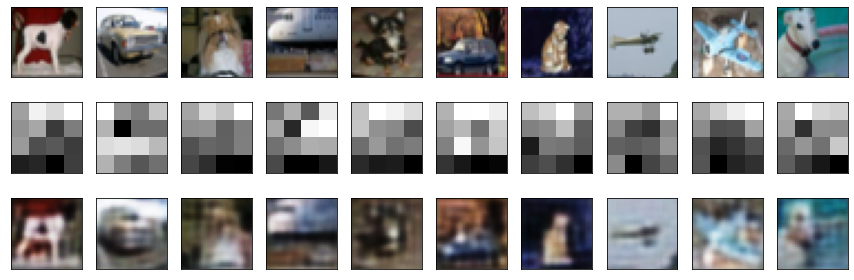

In [95]:
sample = test_dataset.take(1)

test_images = [] 
for img, img in sample:
  test_images = tfds.as_numpy(img)

idxs = np.random.randint(0, 128, 10)

test_images = test_images[idxs]

# get the encoder ouput
encoded = viz.predict(test_images)

print(encoded.shape)

# get a prediction for some values in the dataset
predicted = model.predict(test_images)

# display the samples, encodings and decoded values!
display_results(test_images, encoded, predicted, enc_shape=(4,4))

If you did some visualization like in the ungraded labs, then you might see something like the gallery below. This part is not required.

<img src="https://drive.google.com/uc?export=view&id=12Fy-guiP-3tTPfc9IV2nHhqLvs7LwRo6" width="75%" height="75%"/>

## Save your model

Once you are satisfied with the results, you can now save your model. Please download it from the Files window on the left and go back to the Submission portal in Coursera for grading.

In [96]:
model.save('mymodel.h5')

**Congratulations on completing this week's assignment!**